# Latent Space Variational Geologic  Inversion from Multi-Source Dynamic Data
### Misael M. Morales, 2025
***

In [112]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import time
from sklearn.preprocessing import MinMaxScaler
from skimage.metrics import structural_similarity as ssim
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation

import keras
import tensorflow as tf
import keras.backend as K
from keras import Model, Input
from keras.layers import Conv1D, Conv2D, SeparableConv1D, SeparableConv2D, Conv2DTranspose, Conv1DTranspose
from keras.layers import Dense, EinsumDense, LSTM, ConvLSTM1D, ConvLSTM2D
from keras.layers import Activation, PReLU, LeakyReLU, Add, Multiply, MultiHeadAttention, Embedding
from keras.layers import BatchNormalization, GroupNormalization, LayerNormalization
from keras.layers import AveragePooling2D, MaxPooling2D, UpSampling2D
from keras.layers import Flatten, Reshape, Concatenate, Lambda, RepeatVector, TimeDistributed
from keras.optimizers import Adam, AdamW
from keras.losses import MeanSquaredError, MeanAbsoluteError, KLDivergence

def check_tf_gpu():
    sys_info = tf.sysconfig.get_build_info()
    version, cuda, cudnn = tf.__version__, sys_info["cuda_version"], sys_info["cudnn_version"]
    count = len(tf.config.experimental.list_physical_devices())
    name  = [device.name for device in tf.config.experimental.list_physical_devices('GPU')]
    print('-'*60)
    print('----------------------- VERSION INFO -----------------------')
    print('TF version: {} | # Device(s) available: {}'.format(version, count))
    print('TF Built with CUDA? {} | CUDA: {} | cuDNN: {}'.format(tf.test.is_built_with_cuda(), cuda, cudnn))
    print(tf.config.list_physical_devices()[0],'\n', tf.config.list_physical_devices()[1])
    print('-'*60+'\n')
    return None

def plot_loss(data, figsize=(6,4)):
    plt.figure(figsize=figsize)
    plt.plot(data.history['loss'], label='train')
    plt.plot(data.history['val_loss'], label='validation')
    plt.legend(); plt.grid(True, which='both')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()
    return None

In [3]:
check_tf_gpu()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
TF version: 2.19.0 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.5.1 | cuDNN: 9
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU') 
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
------------------------------------------------------------



In [4]:
nx, ny, nz = 128, 128, 1
nr, nt, nw = 1000, 40, 4

porosity = np.load('simulations_new/data/porosity.npy')
permeability = np.load('simulations_new/data/permeability.npy')
facies = np.load('simulations_new/data/facies.npy')
print('Poro: {} | Perm: {} | Facies: {}'.format(porosity.shape, permeability.shape, facies.shape))

wells = np.load('simulations_new/data/wells.npy')
timesteps = np.load('simulations_new/data/timesteps.npy')
print('Wells: {} | Timesteps: {}'.format(wells.shape, timesteps.shape))

pressure = np.load('simulations_new/data/pressure.npy')
saturation = np.load('simulations_new/data/saturation.npy')
print('Pressure: {} | Saturation: {}'.format(pressure.shape, saturation.shape))

inj_loc = np.array([[63],[63]])
prod_loc = np.array([[0,0,127,127],[0,127,0,127]])
def plot_wells(ax, cs=['w','k'], ms=['v','o'], ss=[25,80]):
    ax.scatter(inj_loc[0], inj_loc[1], c=cs[0], marker=ms[0], s=ss[0])
    ax.scatter(prod_loc[0], prod_loc[1], c=cs[1], marker=ms[1], s=ss[1])
    return None

Poro: (1000, 128, 128) | Perm: (1000, 128, 128) | Facies: (1000, 128, 128)
Wells: (1000, 40, 4, 3) | Timesteps: (40,)
Pressure: (1000, 40, 128, 128) | Saturation: (1000, 40, 128, 128)


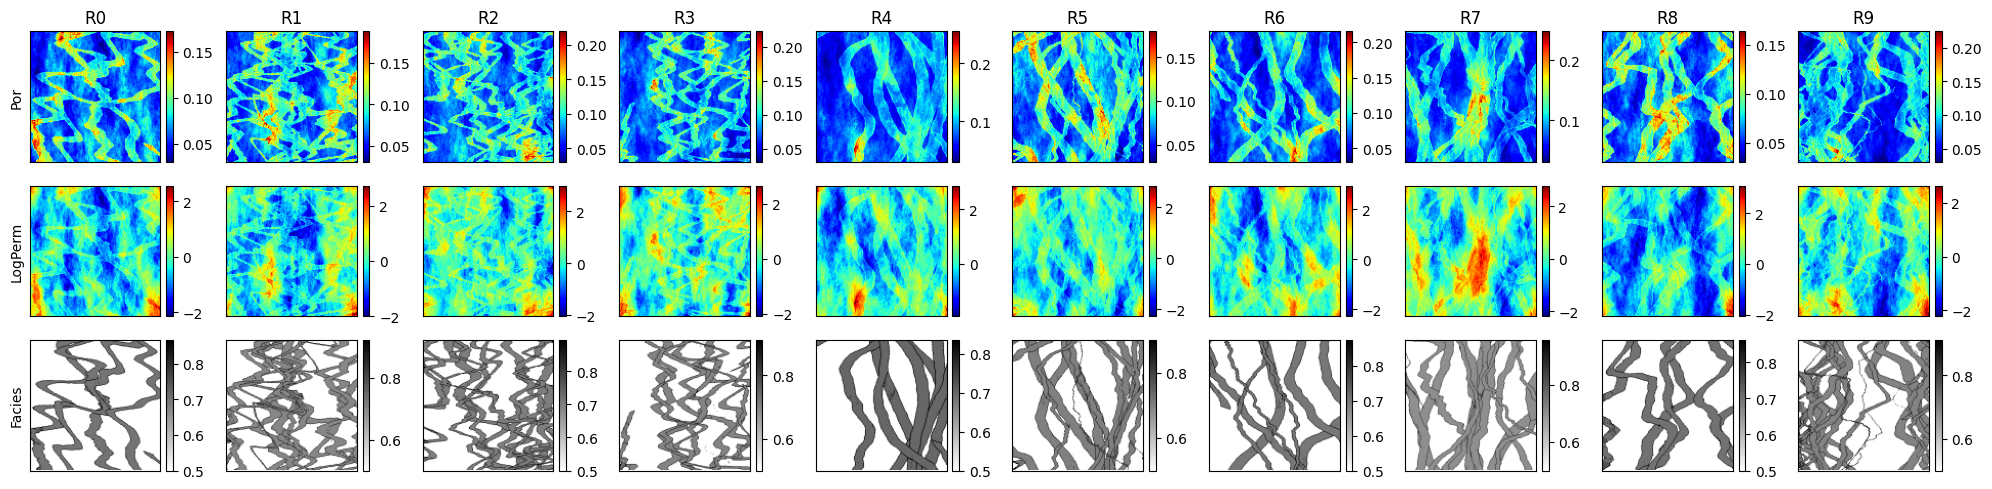

In [70]:
fig, axs = plt.subplots(3, 10, figsize=(20, 5), sharex=True, sharey=True)
for j in range(10):
    ax1, ax2, ax3 = axs[:, j]
    im1 = ax1.imshow(porosity[j], cmap='jet')
    im2 = ax2.imshow(permeability[j], cmap='jet')
    im3 = ax3.imshow(facies[j], cmap='binary')
    ax1.set_title('R{}'.format(j))
    [a.set(xticks=[], yticks=[]) for a in axs[:, j]]
    [a.set_ylabel(['Por','LogPerm','Facies'][i]) for i, a in enumerate([ax1, ax2, ax3]) if j==0]
    [plt.colorbar(im, ax=a, pad=0.04, fraction=0.046) for a, im in zip(axs[:, j], [im1, im2, im3])]
plt.tight_layout()
plt.show()

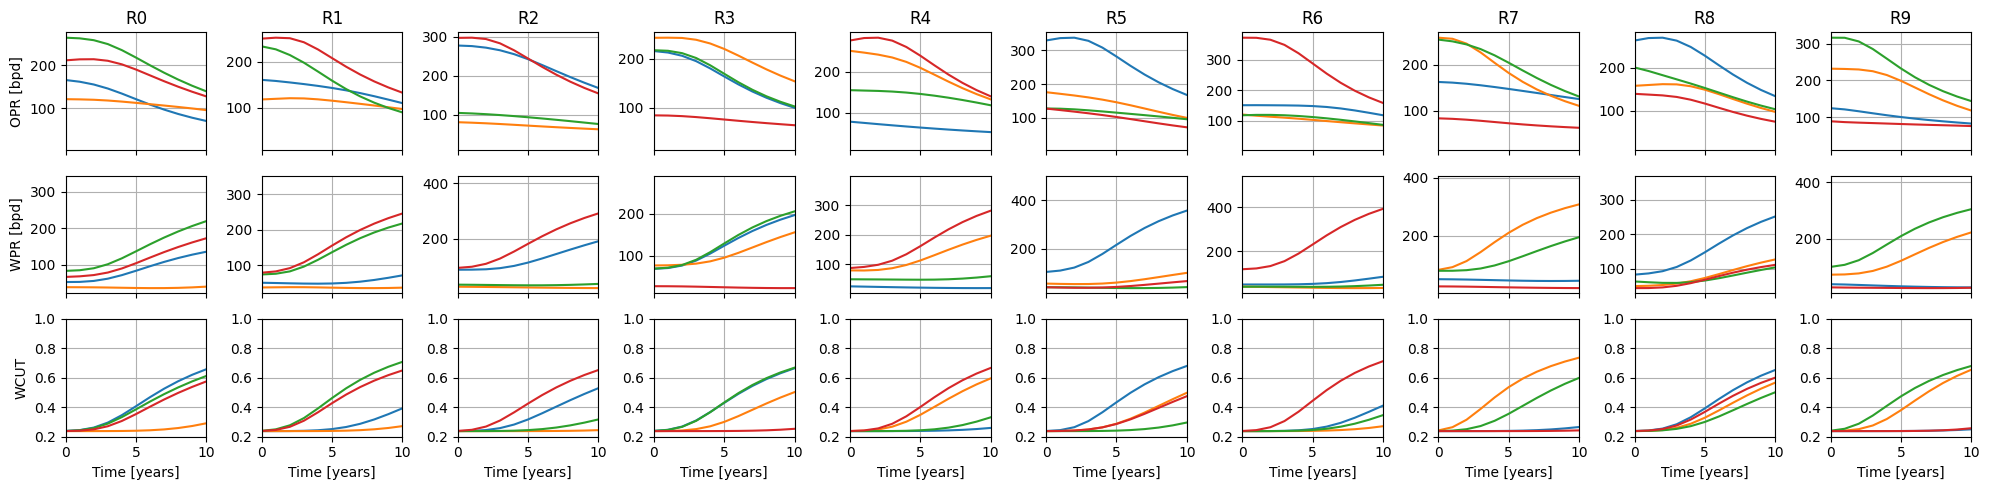

In [71]:
fig, axs = plt.subplots(3, 10, figsize=(20,5), sharex=True)
for j in range(10):
    ax1, ax2, ax3 = axs[:, j]
    ax1.plot(wells[j,:,:,0])
    ax2.plot(wells[j,:,:,1])
    ax3.plot(wells[j,:,:,2])
    [a.grid(True, which='both') for a in axs[:, j]]
    [a.set_xlim(0,10) for a in axs[:,j]]
    ax3.set(ylim=(0.2,1))
    ax3.set(xlabel='Time [years]')
    ax1.set_title('R{}'.format(j))
    [a.set_ylabel(['OPR [bpd]','WPR [bpd]','WCUT'][i]) for i, a in enumerate([ax1, ax2, ax3]) if j==0]

plt.tight_layout()
plt.show()

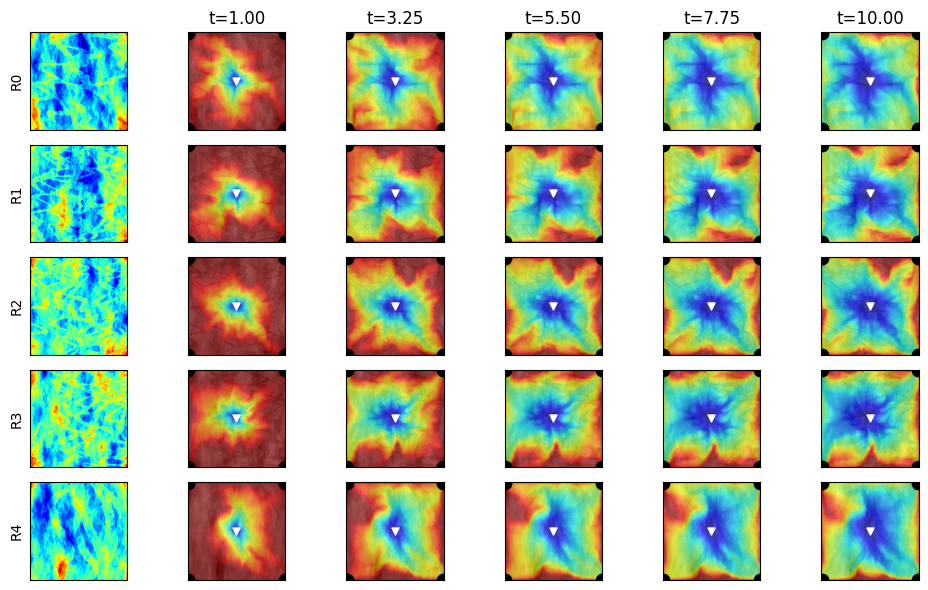

In [72]:
fig, axs = plt.subplots(5, 6, figsize=(10, 6), sharex=True, sharey=True)
for i in range(5):
    axs[i,0].imshow(permeability[i], cmap='jet')
    axs[i,0].set_ylabel('R{}'.format(i))

    for j in range(1,6):
        p = (j-1) * 9 + 3
        ax = axs[i,j]
        ax.imshow(permeability[i], cmap='binary')
        ax.imshow(saturation[i,p], cmap='jet', alpha=0.66)
        ax.scatter(inj_loc[0], inj_loc[1], c='w', marker='v', s=25)
        ax.scatter(prod_loc[0], prod_loc[1], c='k', marker='o', s=80)
        ax.set_title('t={:.2f}'.format(timesteps[p])) if i==0 else None
    
    for j in range(6):
        axs[i,j].set(xticks=[], yticks=[])

plt.tight_layout()
plt.show()

In [73]:
def make_observation_index(nobs:int=20, equigrid:bool=False, nx=128, ny=128):
    if equigrid:
        assert np.sqrt(nobs).is_integer(), 'Number of observations must be a perfect square for equigrid'
        eq_obs = int(np.sqrt(nobs))
        x = np.linspace(eq_obs, nx-1-(eq_obs), eq_obs)
        y = np.linspace(eq_obs, ny-1-(eq_obs), eq_obs)
        xx, yy = np.meshgrid(x, y)
        return np.array([xx.flatten(), yy.flatten()], dtype=int).T
    else:
        randx = np.random.choice(range(nx), nobs, replace=False)
        randy = np.random.choice(range(ny), nobs, replace=False)
        return np.array([randx, randy], dtype=int).T

In [74]:
id_obs = make_observation_index(nobs=49, equigrid=True)
id_dist = np.repeat(np.expand_dims(np.expand_dims(np.moveaxis(np.repeat(cdist(id_obs, inj_loc.T, metric='euclidean'), 40, axis=1), -1, 0), -1), 0), 1000, 0)
id_dist = ((id_dist - id_dist.min()) / (id_dist.max() - id_dist.min())) * 2 - 1

X_data = np.concatenate([np.expand_dims(saturation[...,id_obs[:,0],id_obs[:,1]],-1), 
                         np.expand_dims(pressure[...,:,id_obs[:,0],id_obs[:,1]],-1)], -1)
print('X_data: {}'.format(X_data.shape))

x1 = MinMaxScaler().fit_transform(X_data[...,0].reshape(nr,-1)).reshape(nr, nt, -1, 1)
x2 = MinMaxScaler().fit_transform(X_data[...,1].reshape(nr,-1)).reshape(nr, nt, -1, 1)
X_norm = np.concatenate([x1, x2], -1)
print('X_norm: {} | min={:.2f} | max={:.2f}'.format(X_norm.shape, X_norm.min(), X_norm.max()))

X_data: (1000, 40, 49, 2)
X_norm: (1000, 40, 49, 2) | min=0.00 | max=1.00


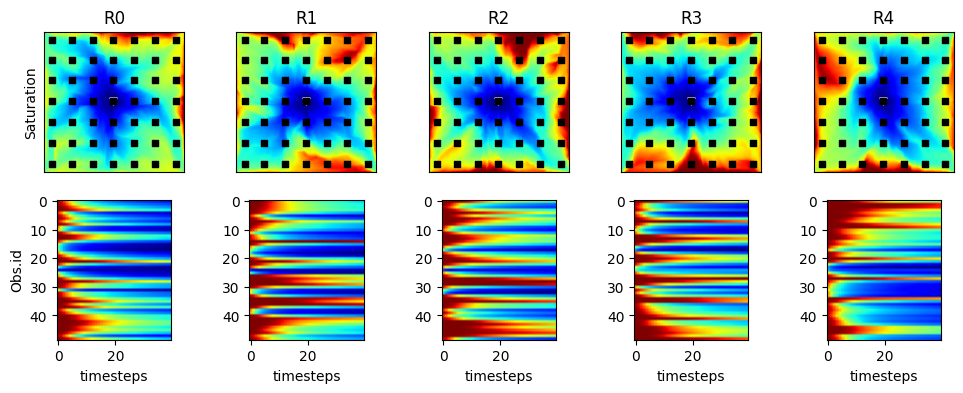

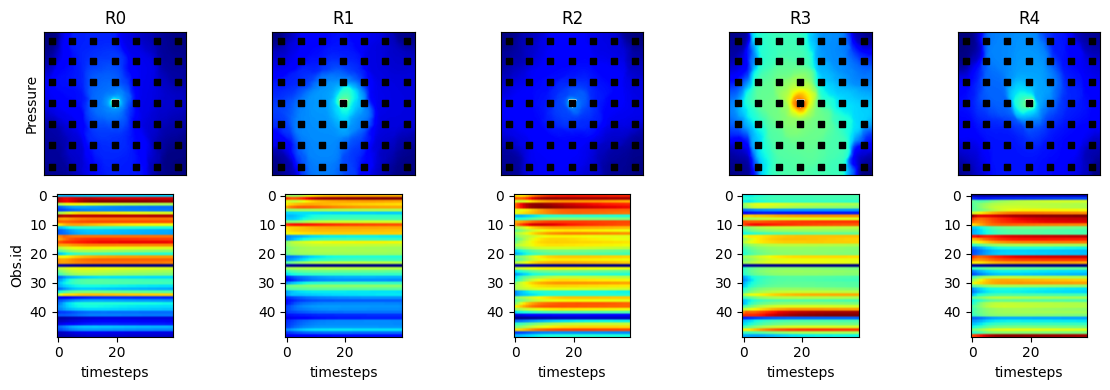

In [75]:
for k in range(2):
    data = [saturation, pressure][k]
    fig, axs = plt.subplots(2, 5, figsize=(12, 4))
    for j in range(5):
        ax1, ax2 = axs[:,j]
        im1 = ax1.imshow(data[j,-1], cmap='jet')
        ax1.scatter(inj_loc[0], inj_loc[1], c='w', marker='v', s=25)
        ax1.scatter(id_obs[:,0], id_obs[:,1], c='k', marker='s', s=20)
        im2 = ax2.imshow(X_norm[j,...,k].T, cmap='jet')
        ax1.set(xticks=[], yticks=[], ylabel=['Saturation','Pressure'][k] if j==0 else None, title='R{}'.format(j))
        ax2.set(xlabel='timesteps', ylabel='Obs.id' if j==0 else None)
plt.tight_layout()
plt.show()

In [76]:
w1 = (wells[...,0] - np.min(wells[...,0])) / (np.max(wells[...,0]) - np.min(wells[...,0]))
w2 = (wells[...,1] - np.min(wells[...,1])) / (np.max(wells[...,1]) - np.min(wells[...,1]))
w3 = (wells[...,2] - np.min(wells[...,2])) / (np.max(wells[...,2]) - np.min(wells[...,2]))
W_norm = np.concatenate([np.expand_dims(w1,-1), np.expand_dims(w2,-1), np.expand_dims(w3,-1)], -1)
print('W_norm: {} | min={:.2f} | max={:.2f}'.format(W_norm.shape, np.min(W_norm), np.max(W_norm)))

W_norm: (1000, 40, 4, 3) | min=0.00 | max=1.00


In [77]:
p = MinMaxScaler().fit_transform(porosity.reshape(nr,-1)).reshape(nr,nx,ny,1)
k = MinMaxScaler().fit_transform(permeability.reshape(nr,-1)).reshape(nr,nx,ny,1)
f = MinMaxScaler().fit_transform(facies.reshape(nr,-1)).reshape(nr,nx,ny,1)
Y_norm = np.concatenate([p, k, f], -1)
print('Y_norm: {}'.format(Y_norm.shape))
print('P: {} | min={:.2f} | max={:.2f}'.format(p.shape, p.min(), p.max()))
print('K: {} | min={:.2f} | max={:.2f}'.format(k.shape, k.min(), k.max()))
print('F: {} | min={:.2f} | max={:.2f}'.format(f.shape, f.min(), f.max()))

Y_norm: (1000, 128, 128, 3)
P: (1000, 128, 128, 1) | min=0.00 | max=1.00
K: (1000, 128, 128, 1) | min=0.00 | max=1.00
F: (1000, 128, 128, 1) | min=0.00 | max=1.00


In [78]:
train_idx = np.random.choice(range(nr), size=int(nr*0.75), replace=False)
test_idx = np.setdiff1d(range(nr), train_idx)
ntrain, ntest = len(train_idx), len(test_idx)
X_train, X_test = X_norm[train_idx], X_norm[test_idx]
W_train, W_test = W_norm[train_idx], W_norm[test_idx]
Y_train, Y_test = Y_norm[train_idx], Y_norm[test_idx]
print('X_train: {} | W_train: {} | Y_train: {}'.format(X_train.shape, W_train.shape, Y_train.shape))
print('X_test:  {} | W_test:  {} | Y_test:  {}'.format(X_test.shape, W_test.shape, Y_test.shape))

X_train: (750, 40, 49, 2) | W_train: (750, 40, 4, 3) | Y_train: (750, 128, 128, 3)
X_test:  (250, 40, 49, 2) | W_test:  (250, 40, 4, 3) | Y_test:  (250, 128, 128, 3)


***
# Model (y) AutoEncoder

In [79]:
def conv_block(inp, filt, kern=(3,3), pool=(2,2), pad='same'):
    _ = SeparableConv2D(filters=filt, kernel_size=kern, padding=pad)(inp)
    _ = SeparableConv2D(filters=filt, kernel_size=kern, padding=pad)(_)
    _ = GroupNormalization(groups=-1)(_)
    _ = BatchNormalization()(_)
    _ = Activation('gelu')(_)
    _ = AveragePooling2D(pool_size=pool)(_)
    return _

def deconv_block(inp, filt, kern=(3,3), pool=(2,2), pad='same'):
    _ = SeparableConv2D(filters=filt, kernel_size=kern, padding=pad)(inp)
    _ = SeparableConv2D(filters=filt, kernel_size=kern, padding=pad)(_)
    _ = GroupNormalization(groups=-1)(_)
    _ = BatchNormalization()(_)
    _ = Activation('gelu')(_)
    _ = UpSampling2D(size=pool)(_)
    return _

def make_static_ae(y):
    inp = Input(shape=(y.shape[1:]))
    _ = conv_block(inp, 4)
    _ = conv_block(_, 64)
    _ = conv_block(_, 128)
    code = SeparableConv2D(256, (3,3), padding='same', activation='relu')(_)
    shape_b4 = code.shape[1:]
    latent = Flatten()(code)
    shape_flat = latent.shape[1]

    z_inp = Input(shape=(shape_flat,))
    _ = Reshape((shape_b4))(z_inp)
    _ = deconv_block(_, 128)
    _ = deconv_block(_, 64)
    _ = deconv_block(_, 4)
    out = SeparableConv2D(3, (3,3), padding='same', activation='sigmoid')(_)

    enc = Model(inputs=inp, outputs=latent, name='static_encoder')
    dec = Model(inputs=z_inp, outputs=out, name='static_decoder')

    output_static = dec(enc(inp))
    ae = Model(inputs=inp, outputs=output_static, name='static_ae')
    return ae, enc, dec

In [80]:
class DualLoss(keras.Loss):
    def __init__(self, alpha=0.5):
        super(DualLoss, self).__init__()
        self.alpha = alpha
        self.mse = MeanSquaredError()

    def call(self, y_true, y_pred):
        mse_loss = self.mse(y_true, y_pred)
        ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
        return self.alpha * mse_loss + (1 - self.alpha) * ssim_loss

I0000 00:00:1747149637.970686    1031 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


# of paramters: 136,230


I0000 00:00:1747149644.151871    9332 service.cc:152] XLA service 0x7f0704076020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747149644.151907    9332 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-05-13 10:20:44.409324: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-13 10:20:44.918819: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/dual_loss/SSIM/Assert/Assert
2025-05-13 10:20:44.919546: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/dual_loss/SSIM/Assert_1/Assert
2025-05-13 10:20:44.920078: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/dual_loss/SSIM/Assert_2/Assert
2025-05-13 10:20:44.920380: W tensorflow/compiler/tf2xla/kernels

Training time: 2.11 min


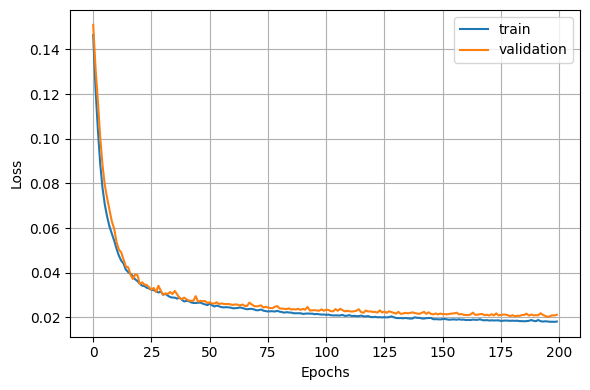

In [81]:
y_ae, y_enc, y_dec = make_static_ae(Y_train)
print('# of paramters: {:,}'.format(y_ae.count_params()))
y_ae.compile(optimizer=Adam(1e-3), metrics=['mse'], loss=DualLoss(alpha=0.9))
start = time()
y_fit = y_ae.fit(Y_train, Y_train, batch_size=16, epochs=200, verbose=0, validation_split=0.2, shuffle=True)
print('Training time: {:.2f} min'.format((time()-start)/60))
plot_loss(y_fit)

In [82]:
Y_train_pred = y_ae.predict(Y_train, verbose=0)
Y_test_pred = y_ae.predict(Y_test, verbose=0)
print('Pred - Train: {} | Test: {}'.format(Y_train_pred.shape, Y_test_pred.shape))

zy_train = y_enc.predict(Y_train, verbose=0).reshape(-1, 16, 16, 256)
zy_test = y_enc.predict(Y_test, verbose=0).reshape(-1, 16, 16, 256)
print('Latent - Train: {} | Test: {}'.format(zy_train.shape, zy_test.shape))

mse_train = np.mean(np.square(Y_train - Y_train_pred))
mse_test = np.mean(np.square(Y_test - Y_test_pred))
print('Train MSE: {:.4f} | Test MSE: {:.4f}'.format(mse_train, mse_test))

Pred - Train: (750, 128, 128, 3) | Test: (250, 128, 128, 3)
Latent - Train: (750, 16, 16, 256) | Test: (250, 16, 16, 256)
Train MSE: 0.0034 | Test MSE: 0.0040


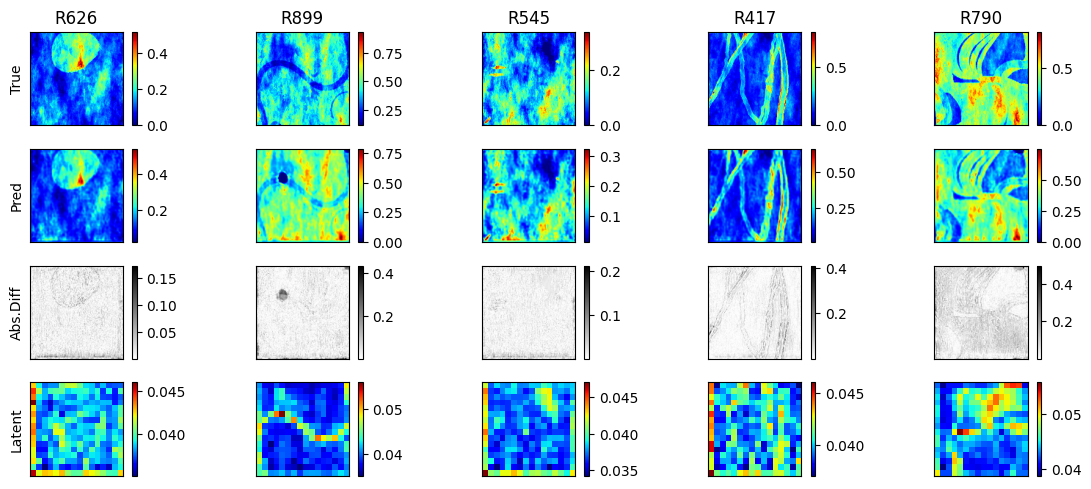

In [83]:
show_channel = 0
mult = 41

fig, axs = plt.subplots(4, 5, figsize=(12,5))
for j in range(5):
    k = j * mult
    ax1, ax2, ax3, ax4 = axs[:, j]
    true, pred = Y_train[k,...,show_channel], Y_train_pred[k,...,show_channel]
    diff = np.abs(true-pred)
    im1 = ax1.imshow(true, cmap='jet')
    im2 = ax2.imshow(pred, cmap='jet')
    im3 = ax3.imshow(diff, cmap='binary')
    im4 = ax4.imshow(zy_train[k].mean(-1), cmap='jet')
    ax1.set_title('R{}'.format(train_idx[k]))
    [a.set(xticks=[], yticks=[]) for a in axs[:, j]]
    [a.set_ylabel(['True','Pred','Abs.Diff','Latent'][i]) for i, a in enumerate([ax1, ax2, ax3, ax4]) if j==0]
    [plt.colorbar(im, ax=a, pad=0.04, fraction=0.046) for a, im in zip(axs[:, j], [im1, im2, im3, im4])]
plt.tight_layout()
plt.show()

***
# Data (X) AutoEncoder

In [84]:
def make_data_ae(x, code_dim:int=512, z_dim:int=256):
    def dense_block(inp, units):
        _ = Dense(units)(inp)
        _ = PReLU()(_)
        return _

    inputs = Input(shape=(x.shape[1:]))
    _ = Flatten()(inputs)
    _ = dense_block(_, code_dim)
    _ = dense_block(_, int((code_dim + z_dim)/2))
    code = dense_block(_, z_dim)

    z_inp = Input(shape=(z_dim,))
    _ = dense_block(z_inp, int((code_dim + z_dim)/2))
    _ = dense_block(_, code_dim)
    _ = dense_block(_, np.prod(x.shape[1:]))
    out = Reshape(x.shape[1:])(_)

    enc = Model(inputs=inputs, outputs=code, name='data_encoder')
    dec = Model(inputs=z_inp, outputs=out, name='data_decoder')
    output_data = dec(enc(inputs))
    ae = Model(inputs=inputs, outputs=output_data, name='data_ae')

    return ae, enc, dec

# of paramters: 4,615,840
Training time: 0.40 min


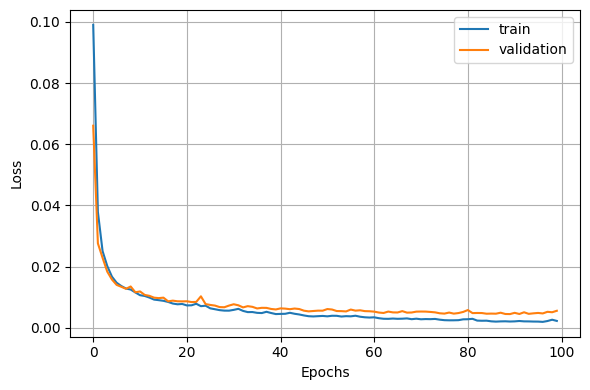

In [85]:
x_ae, x_enc, x_dec = make_data_ae(X_train)
print('# of paramters: {:,}'.format(x_ae.count_params()))
x_ae.compile(optimizer=Adam(1e-3), metrics=['mse'], loss='mse')
start = time()
x_fit = x_ae.fit(X_train, X_train, batch_size=16, epochs=100, verbose=0, validation_split=0.2, shuffle=True)
print('Training time: {:.2f} min'.format((time()-start)/60))
plot_loss(x_fit)

In [86]:
X_train_pred = x_ae.predict(X_train, verbose=0)
X_test_pred = x_ae.predict(X_test, verbose=0)
print('Pred - Train: {} | Test: {}'.format(X_train_pred.shape, X_test_pred.shape))

zx_train = x_enc.predict(X_train, verbose=0).reshape(X_train.shape[0], 16, 16)
zx_test = x_enc.predict(X_test, verbose=0).reshape(X_test.shape[0], 16, 16)
print('Latent - Train: {} | Test: {}'.format(zx_train.shape, zx_test.shape))

mse_train = np.mean(np.square(X_train - X_train_pred))
mse_test = np.mean(np.square(X_test - X_test_pred))
print('Train MSE: {:.4f} | Test MSE: {:.4f}'.format(mse_train, mse_test))

Pred - Train: (750, 40, 49, 2) | Test: (250, 40, 49, 2)
Latent - Train: (750, 16, 16) | Test: (250, 16, 16)
Train MSE: 0.0033 | Test MSE: 0.0056


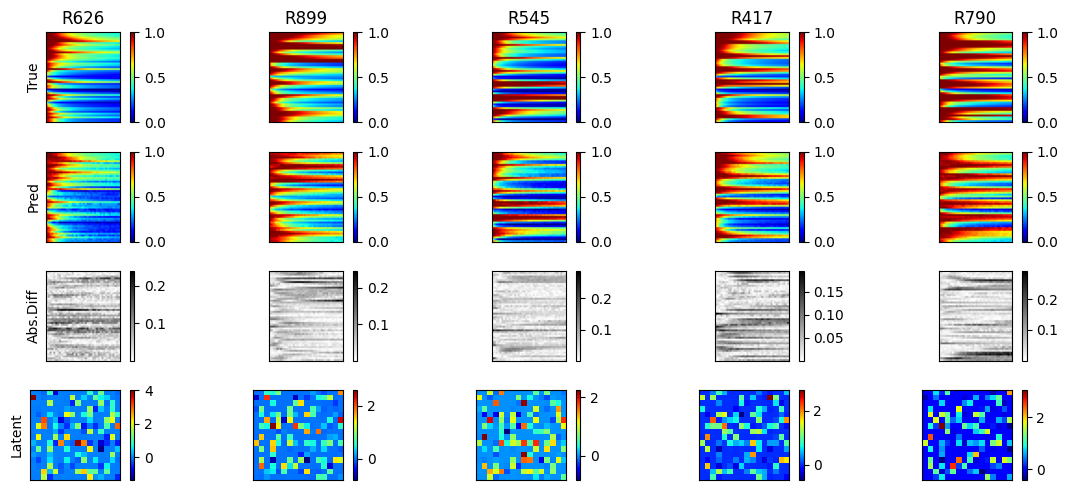

In [87]:
show_channel = 0
mult = 41

fig, axs = plt.subplots(4, 5, figsize=(12,5))
for j in range(5):
    k = j * mult
    ax1, ax2, ax3, ax4 = axs[:, j]
    true, pred = X_train[k,...,show_channel].T, X_train_pred[k,...,show_channel].T
    diff = np.abs(true-pred)
    im1 = ax1.imshow(true, cmap='jet', vmin=0, vmax=1)
    im2 = ax2.imshow(pred, cmap='jet', vmin=0, vmax=1)
    im3 = ax3.imshow(diff, cmap='binary')
    im4 = ax4.imshow(zx_train[k].T, cmap='jet')
    ax1.set_title('R{}'.format(train_idx[k]))
    [a.set(xticks=[], yticks=[]) for a in axs[:, j]]
    [a.set_ylabel(['True','Pred','Abs.Diff','Latent'][i]) for i, a in enumerate([ax1, ax2, ax3, ax4]) if j==0]
    [plt.colorbar(im, ax=a, pad=0.04, fraction=0.046) for a, im in zip(axs[:, j], [im1, im2, im3, im4])]
plt.tight_layout()
plt.show()

***
# Wells (W) AutoEncoder

In [88]:
def make_wells_ae(w, code_dim:int=512, z_dim:int=256):
    t = w.shape[1]
    k = w.shape[2]
    f = w.shape[3]

    inputs = Input(shape=(w.shape[1:]))
    ww = Reshape((t, k*f))(inputs)
    x = LSTM(code_dim, return_sequences=True)(ww)
    x = LSTM(z_dim, return_sequences=False)(x)
    code = x

    z_inp = Input(shape=(z_dim,))
    x = RepeatVector(t)(z_inp)
    x = LSTM(code_dim, return_sequences=True)(x)
    x = LSTM(f*k, return_sequences=True)(x)
    out = Reshape((t, k, f))(x)

    enc = Model(inputs=inputs, outputs=code, name='wells_encoder')
    dec = Model(inputs=z_inp, outputs=out, name='wells_decoder')
    output_data = dec(enc(inputs))
    ae = Model(inputs=inputs, outputs=output_data, name='wells_ae')
    return ae, enc, dec

# of paramters: 3,462,768
Training time: 1.79 min


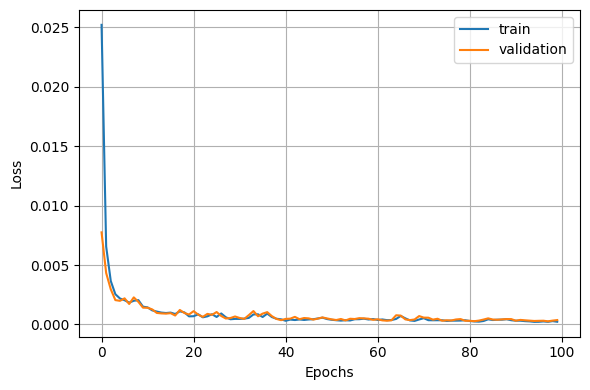

In [89]:
w_ae, w_enc, w_dec = make_wells_ae(W_train)
print('# of paramters: {:,}'.format(w_ae.count_params()))
w_ae.compile(optimizer=Adam(1e-3), metrics=['mse'], loss='mse')
start = time()
w_fit = w_ae.fit(W_train, W_train, batch_size=16, epochs=100, verbose=0, validation_split=0.2, shuffle=True)
print('Training time: {:.2f} min'.format((time()-start)/60))
plot_loss(w_fit)

In [90]:
W_train_pred = w_ae.predict(W_train, verbose=0)
W_test_pred = w_ae.predict(W_test, verbose=0)
print('Pred - Train: {} | Test: {}'.format(W_train_pred.shape, W_test_pred.shape))

zw_train = w_enc.predict(W_train, verbose=0).reshape(W_train.shape[0], 16, 16)
zw_test = w_enc.predict(W_test, verbose=0).reshape(W_test.shape[0], 16, 16)
print('Latent - Train: {} | Test: {}'.format(zw_train.shape, zw_test.shape))

mse_train = np.mean(np.square(W_train - W_train_pred))
mse_test = np.mean(np.square(W_test - W_test_pred))
print('Train MSE: {:.4f} | Test MSE: {:.4f}'.format(mse_train, mse_test))

Pred - Train: (750, 40, 4, 3) | Test: (250, 40, 4, 3)
Latent - Train: (750, 16, 16) | Test: (250, 16, 16)
Train MSE: 0.0003 | Test MSE: 0.0004


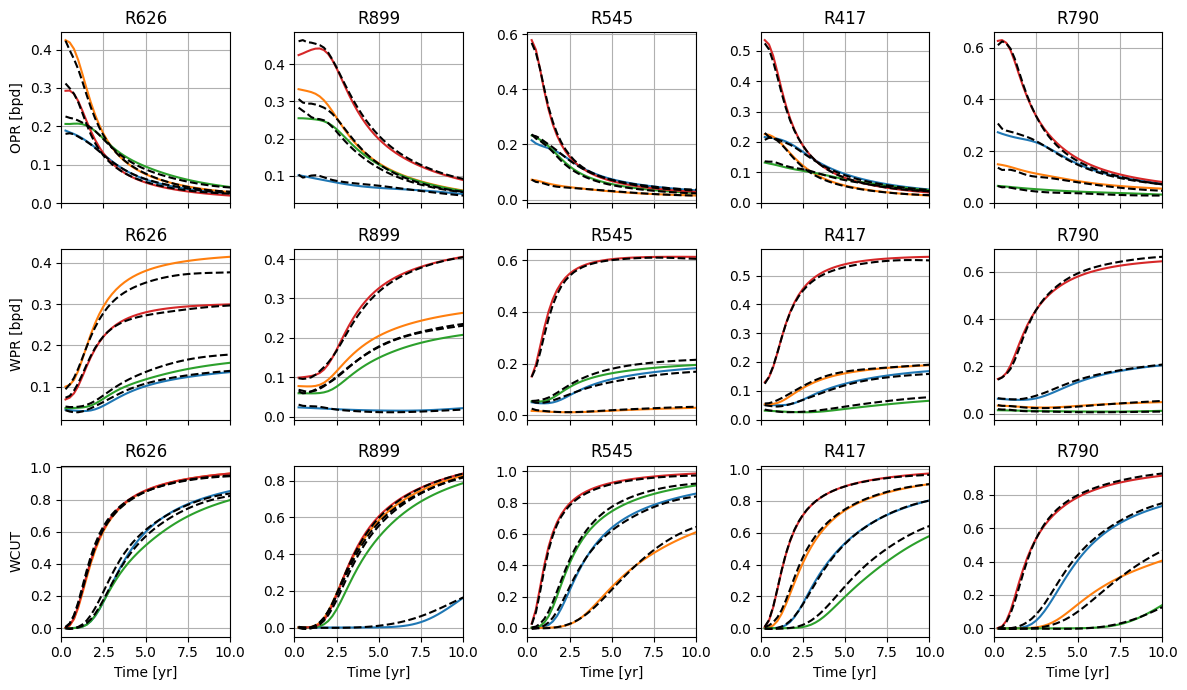

In [91]:
show_channel = 0
mult = 41

fig, axs = plt.subplots(3, 5, figsize=(12,7), sharex=True)
for i in range(3):
    for j in range(5):
        ax = axs[i,j]
        k = j * mult
        true, pred = W_train[k,...,i], W_train_pred[k,...,i]
        diff = (true-pred).mean(-1)
        ax.plot(timesteps, true, ls='-')
        ax.plot(timesteps, pred, ls='--', c='k')
        #ax.plot(timesteps, diff, ls=':', c='k')
        ax.grid(True, which='both')
        ax.set(xlabel='Time [yr]') if i==2 else None
        ax.set(xlim=(0,10), title='R{}'.format(train_idx[k]))
    axs[i,0].set_ylabel(['OPR [bpd]','WPR [bpd]','WCUT'][i])
plt.tight_layout()
plt.show()

***
# Inverse regressor

In [93]:
print('X: {} | W: {} | Y: {}'.format(zx_train.shape, zw_train.shape, zy_train.shape))

X: (750, 16, 16) | W: (750, 16, 16) | Y: (750, 16, 16, 256)


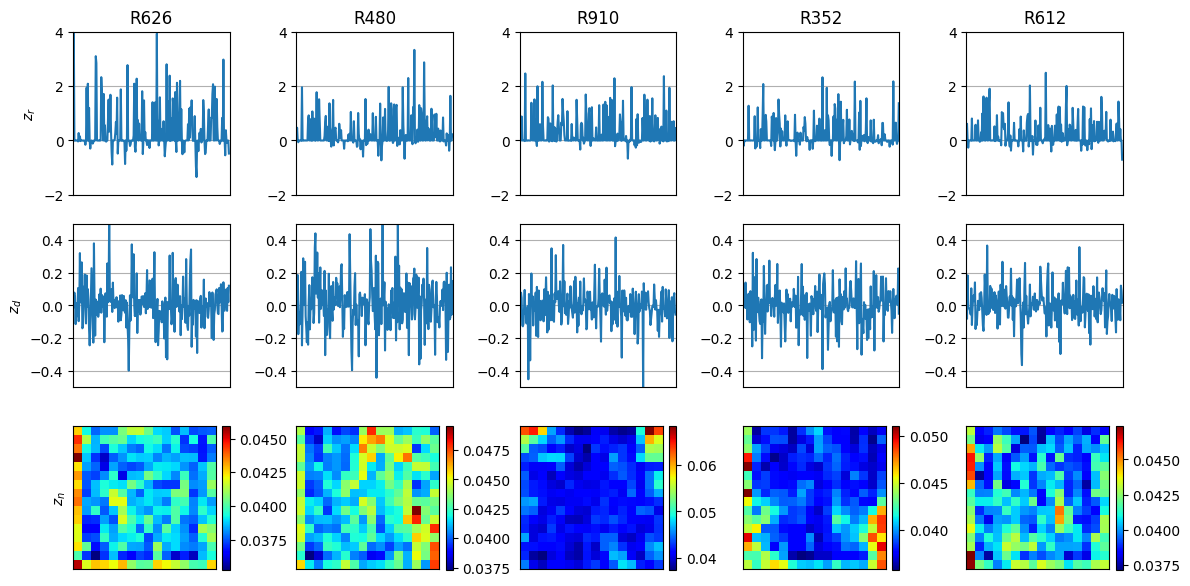

In [95]:
fig, axs = plt.subplots(3, 5, figsize=(12,6))
for j in range(5):
    ax1, ax2, ax3 = axs[:, j]
    im1 = ax1.plot(zx_train[j].reshape(-1))
    im2 = ax2.plot(zw_train[j].reshape(-1))
    im3 = ax3.imshow(zy_train[j].mean(-1), cmap='jet')
    ax1.set_title('R{}'.format(train_idx[j]))
    ax3.set(xticks=[], yticks=[])
    plt.colorbar(im3, ax=ax3, pad=0.04, fraction=0.046)
    [a.set(xticks=[], xlim=(0,256), ylim=[(-2,4),(-0.5,0.5)][i]) for i, a in enumerate([ax1,ax2])]
    [a.grid(True, which='both') for a in [ax1,ax2]]
    [a.set_ylabel(['$z_r$','$z_d$','$z_n$'][i]) for i, a in enumerate([ax1, ax2, ax3]) if j==0]

plt.tight_layout()
plt.show()

In [96]:
class SqueezeExcite(keras.Layer):
    def __init__(self, filters, ratio=16):
        super(SqueezeExcite, self).__init__()
        self.filters = filters
        self.ratio = ratio

    def build(self, input_shape):
        self.se_shape = (1, 1, input_shape[-1])
        self.se_dense1 = Dense(input_shape[-1] // self.ratio)
        self.se_dense2 = Dense(input_shape[-1], activation='sigmoid')
        super(SqueezeExcite, self).build(input_shape)

    def call(self, inputs):
        se = tf.keras.backend.mean(inputs, axis=[1, 2], keepdims=True)
        se = self.se_dense1(se)
        se = tf.keras.backend.relu(se)
        se = self.se_dense2(se)
        return Multiply()([inputs, se])

In [97]:
def make_inv_regressor(zx, zw):
    def conv1_block(inp, filt, kern=3, pad='same'):
        _ = SeparableConv1D(filters=filt, kernel_size=kern, padding=pad)(inp)
        _ = SqueezeExcite(filt)(_)
        _ = GroupNormalization(groups=-1)(_)
        _ = PReLU()(_)
        return _
    def dense_block(inp, units):
        _ = Dense(units)(inp)
        _ = BatchNormalization()(_)
        _ = PReLU()(_)
        return _
    def deconv_block(inp, filt, kern=(3,3), pool=(2,2), pad='same'):
        _ = SeparableConv2D(filters=filt, kernel_size=kern, padding=pad)(inp)
        _ = SqueezeExcite(filt)(_)
        _ = GroupNormalization(groups=-1)(_)
        _ = PReLU()(_)
        _ = Conv2DTranspose(filters=filt, kernel_size=kern, strides=pool, padding=pad)(_)
        return _

    xinp = Input(shape=(zx.shape[1:]))   
    x = Reshape((zx.shape[1]*zx.shape[2], 1))(xinp)
    x = conv1_block(x, 16)
    x = conv1_block(x, 64)
    x = conv1_block(x, 256)
   
    winp = Input(shape=(zw.shape[1:]))
    w = Reshape((zw.shape[1]*zw.shape[2], 1))(winp)
    w = conv1_block(w, 16)
    w = conv1_block(w, 64)
    w = conv1_block(w, 256)

    y = Add()([x, w])
    y = GroupNormalization(groups=-1)(y)
    y = dense_block(y, 256)

    y = Reshape((zx.shape[1], zx.shape[2], 256))(y)
    y = deconv_block(y, 128)
    y = deconv_block(y, 64)
    y = deconv_block(y, 16)
    yout = SeparableConv2D(1, (3,3), padding='same', activation='relu')(y)

    model = Model(inputs=[xinp, winp], outputs=yout, name='inv_regressor')
    return model

In [98]:
def build_train_inv_regressor(channel_select:int, lr=1e-3, loss='mse', epochs=100, batch_size=16, name:str='InvReg'):
    invreg = make_inv_regressor(zx_train, zw_train)
    invreg.compile(optimizer=Adam(lr), metrics=['mse'], loss=loss)
    start = time()
    fit = invreg.fit([zx_train, zw_train], Y_train[...,channel_select], 
                     batch_size=batch_size, epochs=epochs, verbose=0, validation_split=0.2, shuffle=True)
    print('[{}] - # Parameters: {:,} | Training time: {:.2f} min'.format(name, invreg.count_params(), (time()-start)/60))
    return invreg, fit

inv_reg_poro,   fit_poro   = build_train_inv_regressor(0, name='Poro', loss='mse')
inv_reg_perm,   fit_perm   = build_train_inv_regressor(1, name='Perm', loss='mse')
inv_reg_facies, fit_facies = build_train_inv_regressor(2, name='Facies', loss='mae')

2025-05-13 10:30:59.000499: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 416 bytes spill stores, 412 bytes spill loads

2025-05-13 10:30:59.061727: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12_0', 388 bytes spill stores, 388 bytes spill loads

2025-05-13 10:30:59.111655: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 404 bytes spill stores, 400 bytes spill loads

2025-05-13 10:30:59.140773: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12_0', 16 bytes spill stores, 16 bytes spill loads

2025-05-13 10:30:59.276116: I external

[Poro] - # Parameters: 752,024 | Training time: 1.59 min
[Perm] - # Parameters: 752,024 | Training time: 1.37 min
[Facies] - # Parameters: 752,024 | Training time: 1.36 min


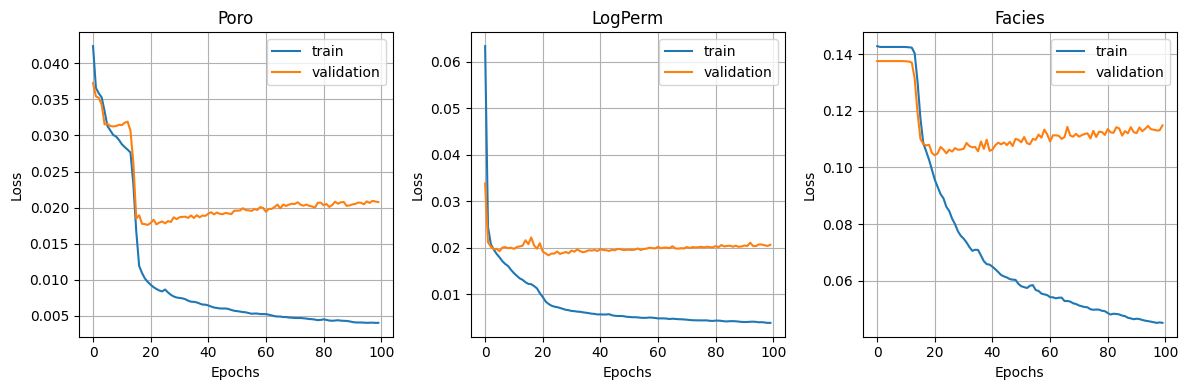

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
ax1, ax2, ax3 = axs

ax1.plot(fit_poro.history['loss'], label='train')
ax1.plot(fit_poro.history['val_loss'], label='validation')

ax2.plot(fit_perm.history['loss'], label='train')
ax2.plot(fit_perm.history['val_loss'], label='validation')

ax3.plot(fit_facies.history['loss'], label='train')
ax3.plot(fit_facies.history['val_loss'], label='validation')

[a.legend() for a in axs]
[a.grid(True, which='both') for a in axs]
[a.set(xlabel='Epochs', ylabel='Loss', title=['Poro','LogPerm','Facies'][i]) for i,a in enumerate(axs)]
plt.tight_layout()
plt.show()

In [100]:
pinv_train = inv_reg_poro.predict([zx_train, zw_train], verbose=0)
pinv_test  = inv_reg_poro.predict([zx_test, zw_test], verbose=0)

kinv_train = inv_reg_perm.predict([zx_train, zw_train], verbose=0)
kinv_test  = inv_reg_perm.predict([zx_test, zw_test], verbose=0)

finv_train = inv_reg_facies.predict([zx_train, zw_train], verbose=0)
finv_test  = inv_reg_facies.predict([zx_test, zw_test], verbose=0)

Y_inv_train = np.concatenate([pinv_train, kinv_train, finv_train], -1)
Y_inv_test  = np.concatenate([pinv_test,  kinv_test,  finv_test], -1)
print('Latent inversion - Train: {} | Test: {}'.format(Y_inv_train.shape, Y_inv_test.shape))

mse_train = np.mean(np.square(Y_train - Y_inv_train))
mse_test = np.mean(np.square(Y_test - Y_inv_test))
print('Train MSE: {:.4f} | Test MSE: {:.4f}'.format(mse_train, mse_test))

2025-05-13 10:35:13.919754: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12_0', 388 bytes spill stores, 388 bytes spill loads

2025-05-13 10:35:14.557556: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 416 bytes spill stores, 412 bytes spill loads

2025-05-13 10:35:14.597167: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 404 bytes spill stores, 400 bytes spill loads

2025-05-13 10:35:14.655131: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12_0', 1388 bytes spill stores, 1380 bytes spill loads

2025-05-13 10:35:14.847319: I exte

Latent inversion - Train: (750, 128, 128, 3) | Test: (250, 128, 128, 3)
Train MSE: 0.0098 | Test MSE: 0.0262


Sample: 4 | MSE: 0.0025 | SSIM: 0.7317


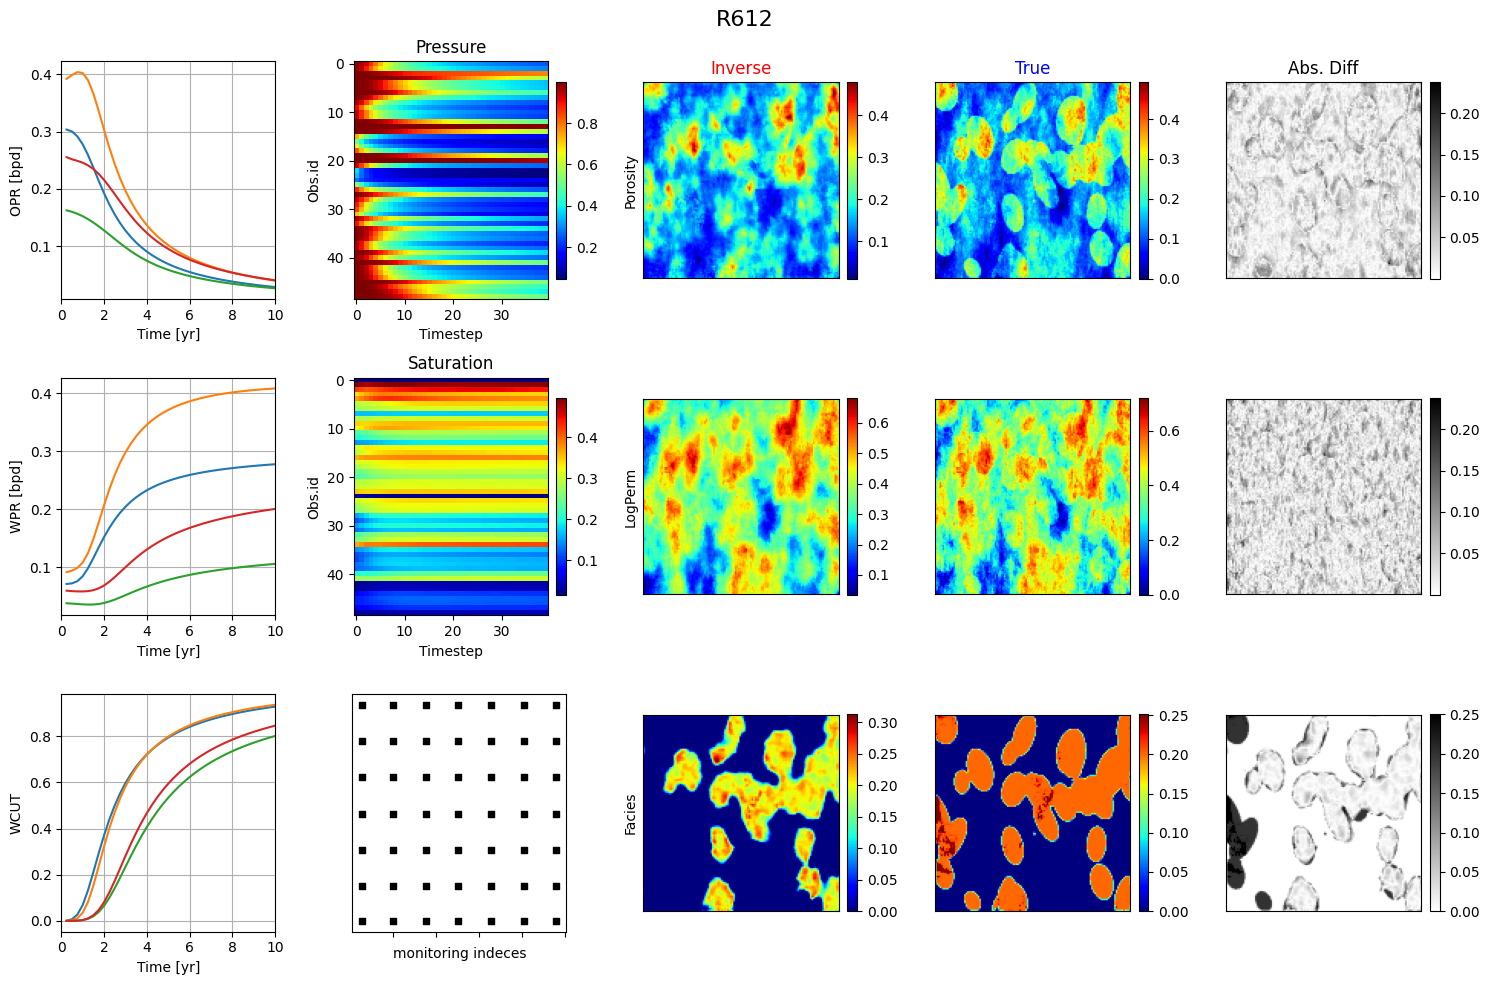

In [132]:
sample = 4 ### 166 362 516 98

e_mse = np.mean(np.square(Y_train[sample] - Y_inv_train[sample]))
e_ssim = ssim(Y_train[sample], Y_inv_train[sample], multichannel=True, data_range=1.0, channel_axis=-1)
print('Sample: {} | MSE: {:.4f} | SSIM: {:.4f}'.format(sample, e_mse, e_ssim))


fig, axs = plt.subplots(3, 5, figsize=(15,10))

axs[-1,1].scatter(id_obs[:,0], id_obs[:,1], c='k', marker='s', s=20)
axs[-1,1].set_xlabel('monitoring indeces')
axs[-1,1].set(xticklabels=[], yticks=[])

for i in range(3):
    true = Y_train[sample,...,i]
    pred = Y_inv_train[sample,...,i]
    diff = np.abs((true-pred))

    axs[i,0].plot(timesteps, W_train[sample,...,i])
    axs[i,0].set(xlim=(0,10), xlabel='Time [yr]', ylabel=['OPR [bpd]','WPR [bpd]','WCUT'][i])
    axs[i,0].grid(True, which='both')
    
    im2 = axs[i,2].imshow(pred, cmap='jet')
    axs[i,2].set(ylabel=['Porosity','LogPerm','Facies'][i], xticks=[], yticks=[])
    axs[i,2].set_title('Inverse', color='r') if i==0 else None

    im3 = axs[i,3].imshow(true, cmap='jet')
    axs[i,3].set_title('True', color='b') if i==0 else None

    im4 = axs[i,4].imshow(diff, cmap='binary')
    axs[i,4].set_title('Abs. Diff', color='k') if i==0 else None
    
    for j in range(3,5):
        axs[i,j].set(xticks=[], yticks=[])
    [plt.colorbar(ii, ax=axs[i,jj], pad=0.04, fraction=0.046) for ii, jj in zip([im2, im3, im4], range(2,5))]

for i in range(2):
    im = axs[i,1].imshow(X_train[sample,...,i].T, cmap='jet')
    axs[i,1].set(xlabel='Timestep', ylabel='Obs.id', title=['Pressure','Saturation'][i])
    plt.colorbar(im, ax=axs[i,1], pad=0.04, fraction=0.046)

plt.suptitle('R{}'.format(train_idx[sample]), fontsize=16)
plt.tight_layout()
plt.show()

***
## Latent space distributions

Poro: 0.53 | LogPerm: 0.47 | Facies: 0.79 | Latent: 0.09


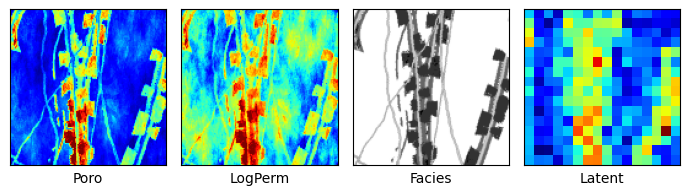

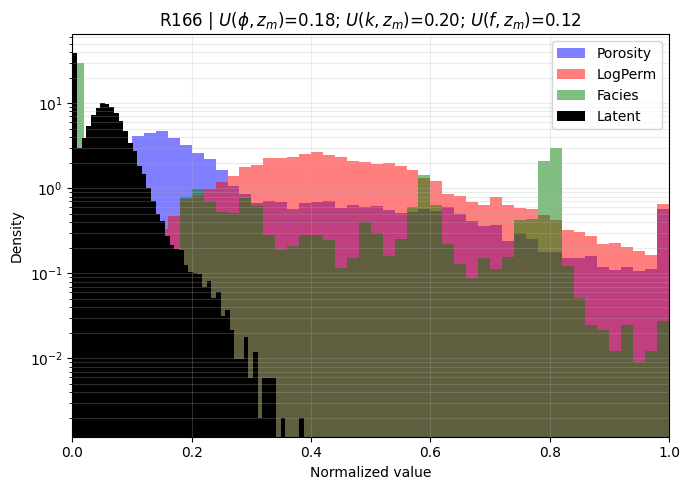

In [251]:
sample = 651
p = Y_train[sample,...,0].flatten()
k = Y_train[sample,...,1].flatten()
f = Y_train[sample,...,2].flatten()
l = zy_train[sample].flatten()

u_p = np.percentile(p, 90) - np.percentile(p, 10)
u_k = np.percentile(k, 90) - np.percentile(k, 10)
u_f = np.percentile(f, 90) - np.percentile(f, 10)
u_l = np.percentile(l, 90) - np.percentile(l, 10)
print('Poro: {:.2f} | LogPerm: {:.2f} | Facies: {:.2f} | Latent: {:.2f}'.format(u_p, u_k, u_f, u_l))

fig, axs = plt.subplots(1, 4, figsize=(7,3))
axs[0].imshow(p.reshape(nx,ny), cmap='jet')
axs[1].imshow(k.reshape(nx,ny), cmap='jet')
axs[2].imshow(f.reshape(nx,ny), cmap='binary')
axs[3].imshow(zy_train[sample].mean(-1), cmap='jet')
for j in range(4):
    axs[j].set(xticks=[], yticks=[])
    axs[j].set(xlabel=['Poro','LogPerm','Facies','Latent'][j])
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.hist(p, bins=50, alpha=0.5, label='Porosity', color='b', density=True)
plt.hist(k, bins=50, alpha=0.5, label='LogPerm', color='r', density=True)
plt.hist(f, bins=50, alpha=0.5, label='Facies', color='g', density=True)
plt.hist(l, bins=50, alpha=1, label='Latent', color='k', density=True)
plt.legend(); plt.grid(True, which='both', alpha=0.25)
plt.yscale('log'); plt.xlim(0,1); plt.xlabel('Normalized value'); plt.ylabel('Density')
plt.title('R{} | $U(\phi,z_m)$={:.2f}; $U(k,z_m)$={:.2f}; $U(f,z_m)$={:.2f}'.format(train_idx[sample], u_l/u_p, u_l/u_k, u_l/u_f))
plt.tight_layout()
plt.show()

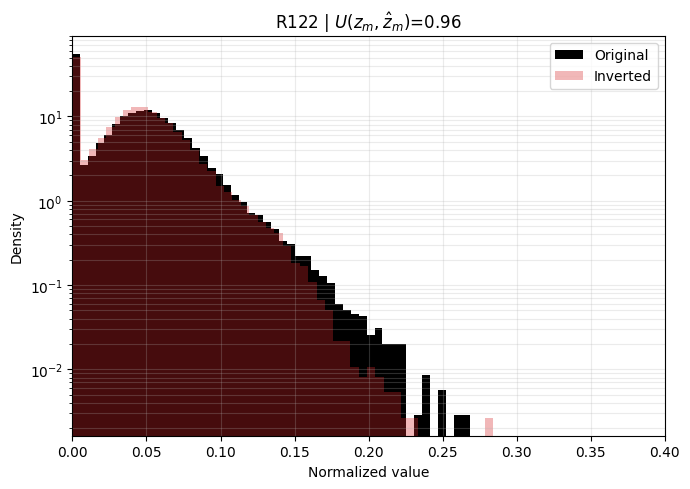

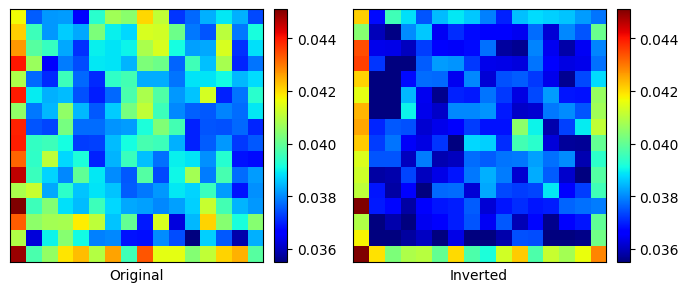

In [309]:
sample = np.argwhere(train_idx==122)[0][0]

zori = zy_train[sample].flatten()
zinv = np.array(y_enc(Y_inv_train[sample].reshape(1,128,128,3))).flatten()
u_z = (np.percentile(zinv,90)-np.percentile(zinv,10))/(np.percentile(zori,90)-np.percentile(zori,10))

plt.figure(figsize=(7,5))
plt.hist(zori, bins=50, alpha=1, label='Original', color='k', density=True)
plt.hist(zinv, bins=50, alpha=0.33, label='Inverted', color='tab:red', density=True)
plt.legend(); plt.grid(True, which='both', alpha=0.25)
plt.yscale('log'); plt.xlim(0, 0.4); plt.xlabel('Normalized value'); plt.ylabel('Density')
plt.title(r'R{} | $U(z_m,\^z_m)$={:.2f}'.format(train_idx[sample], u_z))
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(7,3), sharex=True, sharey=True)
im1 = axs[0].imshow(zy_train[sample].mean(-1), cmap='jet')
im2 = axs[1].imshow(np.array(y_enc(Y_inv_train[sample].reshape(1,128,128,3))).reshape(16,16,256).mean(-1), cmap='jet', vmin=im1.get_clim()[0], vmax=im1.get_clim()[1])
[plt.colorbar(ii, ax=aa, pad=0.04, fraction=0.046) for ii, aa in zip([im1, im2], axs)]
[a.set(xticks=[], yticks=[]) for a in axs]
[a.set(xlabel=['Original','Inverted'][i]) for i, a in enumerate(axs)]
plt.tight_layout()
plt.show()

***
# END